# Individual Variability across cerebellum

In [2]:
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import Functional_Fusion.dataset as ds
import ProbabilisticParcellation.util as ut
from copy import deepcopy
import ProbabilisticParcellation.learn_fusion_gpu as lf
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as sc
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sm
from PcmPy import indicator
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.evaluation as ev
import Functional_Fusion.atlas_map as am
import SUITPy as suit
import os
import ProbabilisticParcellation.scripts.atlas_paper.individual_variability as var
import nitools as nt
import nibabel as nb
from scipy.stats import ttest_rel, ttest_ind


In [3]:
# Figure settings
figsize = (8, 8)
colorbar = True
bordersize = 4
dtype = 'func'
cmap = 'inferno'
cscale = (0.2, 1)
labels = None,

background = 'white'
if background == 'black':
    fontcolor = 'w'
    bordercolor = 'w'
    backgroundcolor = 'k'
elif background == 'white':
    fontcolor = 'k'
    bordercolor = 'k'
    backgroundcolor = 'w'


In [4]:
T = pd.read_csv(ut.base_dir + "/dataset_description.tsv", sep="\t")
Data, Info = [], []
for d, dname in enumerate(T.name[:-1]):
    data, info, dset = ds.get_dataset(ut.base_dir, dname, atlas="MNISymC2")
    Data.append(data)
    Info.append(info)

/Users/callithrix/code/Python/Functional_Fusion/Functional_Fusion/dataset.py:558: UserWarning: sub-11, ses-preference, CondHalf - missing data painting_constant-half2
  warnings.warn(


In [5]:
# Get inter-individual variability for plotting
Corr, Corr_norm, Rel = var.calc_variability(Data, Info, subject_wise=False)


/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:173: RuntimeWarning: Mean of empty slice
  correlation = np.nanmean(
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:176: RuntimeWarning: Mean of empty slice
  noise_ceiling = np.nanmean(


# Plot Variabilities

In [7]:
suit_atlas, _ = am.get_atlas("MNISymC2", ut.base_dir + "/Atlases")

In [ ]:
Corr_norm[0].shape

# Averaged across datasets (Fig 5b)

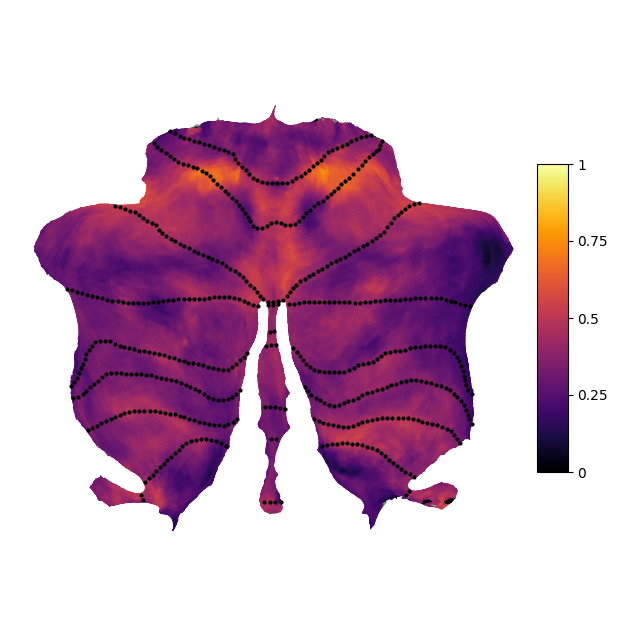

In [10]:
# Average Corr_norm values
exclude = []
Corr_norm_mean = np.nanmean([Corr_norm[i] for i in range(len(Corr_norm)) if T.name[i] not in exclude], axis=0)
# Plot average Corr_norm
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
# Plot normalized individual variability
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    colorbar=colorbar,
    cmap=cmap,
    bordercolor=bordercolor,
    backgroundcolor=backgroundcolor,
    bordersize=bordersize,
    cscale=(0,1),
)
filename = f"var_norm_mean_all"
plt.savefig(f"{ut.figure_dir}/individual_variability/{filename}_{background}.png",
            dpi=300, bbox_inches="tight")


## MDTB

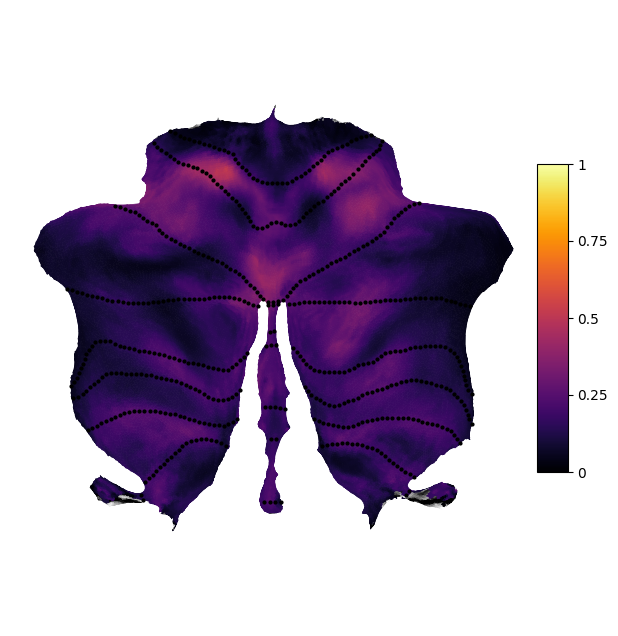

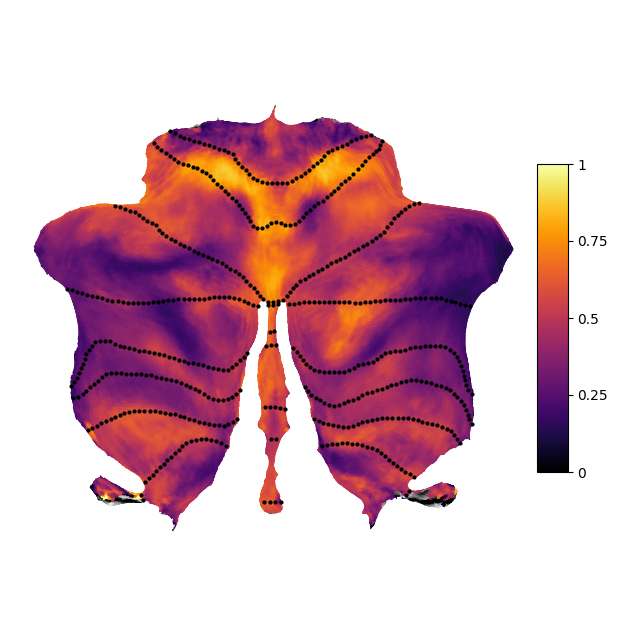

In [6]:
dataset = 'MDTB'
d = np.where([T.name == dataset])[0].item()

# Plot individual variability
Nifti = suit_atlas.data_to_nifti(Corr[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    colorbar=colorbar,
    cmap=cmap,
    bordercolor=bordercolor,
    backgroundcolor=backgroundcolor,
    bordersize=bordersize,
    cscale=cscale,
)
filename = f"var_{dataset}"
plt.savefig(f"{ut.figure_dir}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")



In [ ]:


# Plot normalized individual variability
Nifti = suit_atlas.data_to_nifti(Corr_norm[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    colorbar=colorbar,
    cmap=cmap,
    bordercolor=bordercolor,
    backgroundcolor=backgroundcolor,
    bordersize=bordersize,
    cscale=cscale,
)
filename = f"var_norm_{dataset}_norm"
plt.savefig(f"{ut.figure_dir}/individual_variability/{filename}_{background}.png", dpi=300, bbox_inches="tight")

# Variability projected into Parcels

In [10]:
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'

# --- Get 32 parcel ---
mname = 'Models_03/NettekovenSym32_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)
# Import labels
_, cmap_32, labels_32 = nt.read_lut(lut_dir +
                              f'{split_mn[0].split("_space")[0]}.lut')
labels_32=labels_32[1:]
cmap_32=cmap_32[1:]

# Get winner take-all
Prob = np.array(model.marginal_prob())
parcel_32 = Prob.argmax(axis=0) + 1

# --- Get 68 parcel ---
mname = 'Models_03/NettekovenSym68_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)
# Import labels
_, cmap_68, labels_68 = nt.read_lut(lut_dir +
                              f'{split_mn[0].split("_space")[0]}.lut')
labels_68=labels_68[1:]
cmap_68=cmap_68[1:]

# Get winner take-all
Prob = np.array(model.marginal_prob())
parcel_68 = Prob.argmax(axis=0) + 1

In [11]:
# Map the variability to the parcels   
Nifti = suit_atlas.data_to_nifti(parcel_32.astype(float))
surf_parcel_32 = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel_32 = np.nan_to_num(surf_parcel_32, copy=False).astype(int)

Nifti = suit_atlas.data_to_nifti(parcel_68.astype(float))
surf_parcel_68 = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel_68 = np.nan_to_num(surf_parcel_68, copy=False).astype(int)

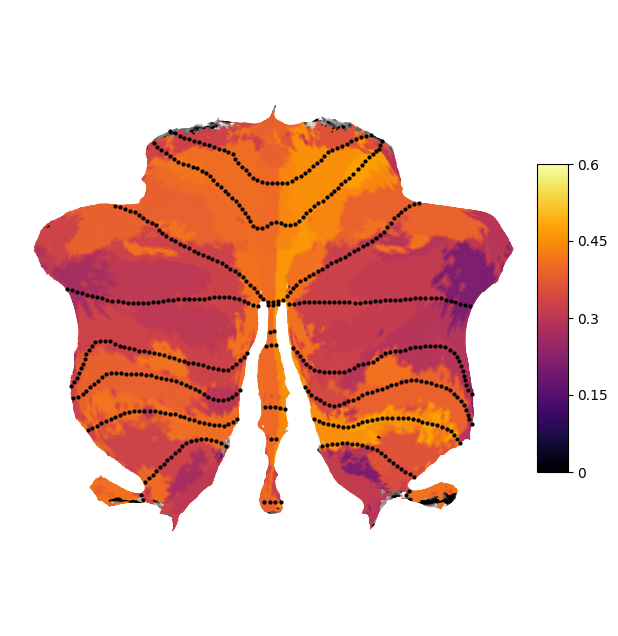

In [25]:
# Plot mean variability in K32
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")

corr_map = np.zeros(surf_parcel_32.shape) * np.nan
for p in np.arange(1, surf_parcel_32.max() + 1):
    mask = (surf_parcel_32 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])



# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(corr_map,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  colorbar=colorbar,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  cscale=(0, 0.6),)
plt.savefig(ut.figure_dir + '/individual_variability/var_parcel_norm_32-all.png',
            dpi=300, bbox_inches='tight')


## MDTB Variability

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_8123/1384593177.py:7: RuntimeWarning: Mean of empty slice
  corr_map[mask] = np.nanmean(surf_data[mask])


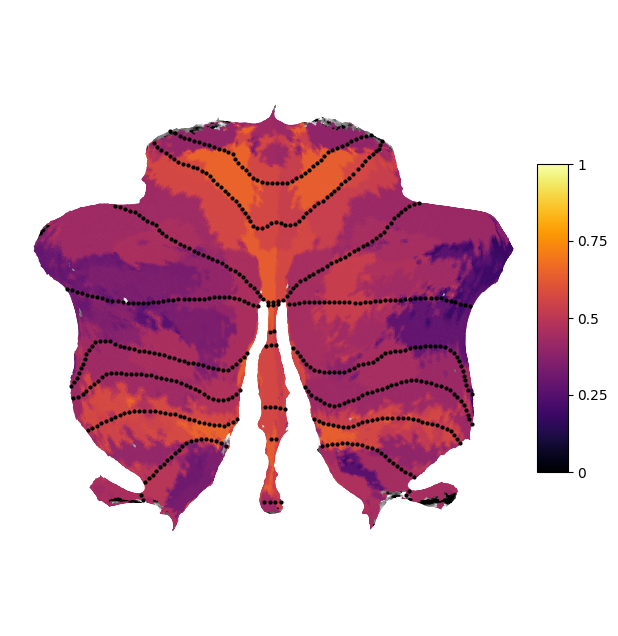

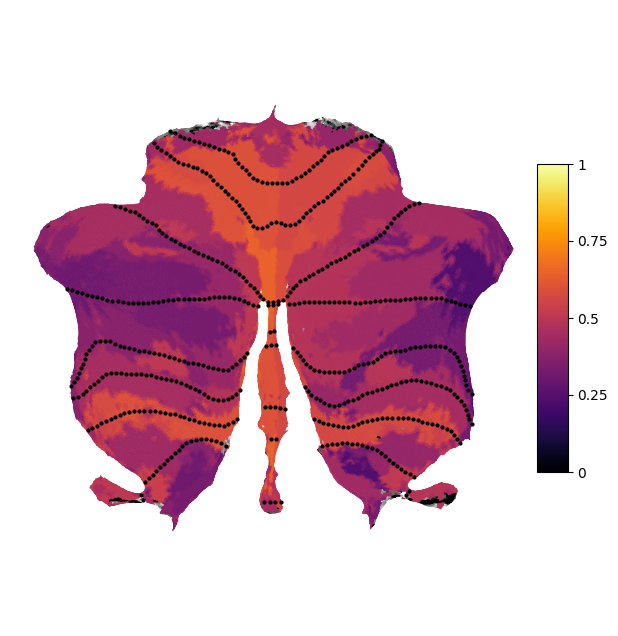

In [13]:
# Plot MDTB variability in K68
Nifti = suit_atlas.data_to_nifti(Corr_norm[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
corr_map = np.zeros(surf_parcel_68.shape) * np.nan
for p in np.arange(1,surf_parcel_68.max()+1):
    mask = (surf_parcel_68 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=colorbar,
                    cmap=cmap,
                    bordercolor=bordercolor,
                    backgroundcolor=backgroundcolor,
                    bordersize=bordersize,
                    cscale=cscale,)
plt.savefig(ut.figure_dir + '/individual_variability/var_parcel_norm_68-mdtb.png',
            dpi=300, bbox_inches='tight')


# Plot MDTB variability in K32
corr_map = np.zeros(surf_parcel_32.shape) * np.nan
for p in np.arange(1,surf_parcel_32.max()+1):
    mask = (surf_parcel_32 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=colorbar,
                    cmap=cmap,
                    bordercolor=bordercolor,
                    backgroundcolor=backgroundcolor,
                    bordersize=bordersize,
                    cscale=cscale,)
plt.savefig(ut.figure_dir + '/individual_variability/var_parcel_norm_32-mdtb.png',
            dpi=300, bbox_inches='tight')

